## Bike-rental Demand Forecasting

Objective: to forecast demand of bike rentals by hour

Dataset available: Data from Capital Bikeshare program in Washington, D.C.; Split into 2 datasets: test (20th - end of each month) and train (1 - 19th of each month).

Possible questions:
1. Which variables will be key drivers of bike-rental demand by hour

In [174]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from datetime import datetime
from sklearn.model_selection import train_test_split  
from sklearn.linear_model import LinearRegression

# 1. Data Preparation of Train data & Overview of Variables

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


# Description of variables:

- Datetime: hourly date + timestamp

- Season: 1 = spring, 2 = summer, 3 = fall, 4 = winter

- holiday - whether the day is considered a holiday

- workingday - whether the day is neither a weekend nor holiday

- weather - 1: Clear, Few clouds, Partly cloudy;2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist; 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds; 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

- temp - temperature in Celsius

- atemp - "feels like" temperature in Celsius

- humidity - relative humidity

- windspeed - wind speed

- casual - number of non-registered user rentals initiated

- registered - number of registered user rentals initiated

- count - number of total rentals

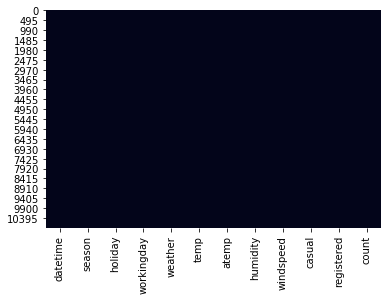

In [5]:
sns.heatmap(df.isnull(), cbar = False)

- Graph above plots rows where there is null values. No plot indicates that there are no null values in dataset

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


In [7]:
from datetime import datetime

In [8]:
df['datetime'] = pd.to_datetime(df.datetime)

In [120]:
df['count'].groupby(df.datetime.dt.year).sum()

datetime
2011     781979
2012    1303497
Name: count, dtype: int64

- Total bike rentals increased from 2011 to 2012, almost doubling.

Text(0.5,1,'Daily Total Bike Usage')

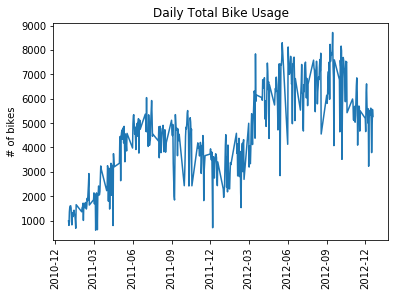

In [96]:
df['count'].groupby(df.datetime.dt.date).sum().plot()
plt.xlabel('')
plt.xticks(rotation = 90)
plt.ylabel('# of bikes')
plt.title('Daily Total Bike Usage')

Sales increases towards midyear (June to September) in both 2011 and 2012.

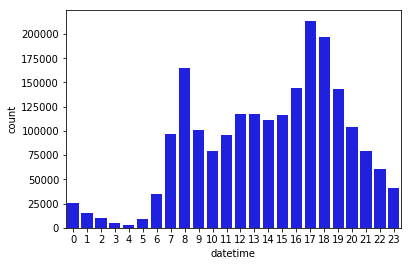

In [314]:
sns.barplot(x = df.datetime.dt.hour, y = df['count'].groupby(df.datetime.dt.hour).sum(), data = df, color = 'blue')

In [308]:
xtick = np.linspace(1,24,24)

In [136]:
correlation_matrix = df.drop(columns = ['season','holiday','workingday','weather']).corr()

- below shows the correlation between available variables against 'count', which is the total # bikes used daily

In [141]:
correlation_matrix['casual']

temp          0.467097
atemp         0.462067
humidity     -0.348187
windspeed     0.092276
casual        1.000000
registered    0.497250
count         0.690414
Name: casual, dtype: float64

In [138]:
correlation_matrix

,temp,atemp,humidity,windspeed,casual,registered,count
temp,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454
atemp,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784
humidity,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371
windspeed,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369
casual,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414
registered,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948
count,0.394454,0.389784,-0.317371,0.101369,0.690414,0.970948,1.000000


- Temperature and Temperature-feel(atemp) are weakly correlated with demand for bikes, while humidity is weakly negatively correlated.
- Season, Holiday, workingday, and Weather cannot be tested for correlation, but can be tested in the model using dummy variables
-  temperature and atemp are highly correlated. Temperature is more strongly correlated with demand (count) and will be used in favor over atemp

# 2. Preparing data for Machine Learning

In [542]:
df_linear_reg = df.drop(columns = ['casual', 'registered', 'season','weather','Month','Year','MonthYear','windspeed', 'atemp'])

In [543]:
df_linear_reg.head()

,datetime,holiday,workingday,temp,humidity,count
0,2011-01-01 00:00:00,0,0,9.84,81,16
1,2011-01-01 01:00:00,0,0,9.02,80,40
2,2011-01-01 02:00:00,0,0,9.02,80,32
3,2011-01-01 03:00:00,0,0,9.84,75,13
4,2011-01-01 04:00:00,0,0,9.84,75,1


In [544]:
season_dummy = pd.get_dummies(df['season'], drop_first=True)

In [545]:
season_dummy.columns = ['Summer', 'Fall', 'Winter']
season_dummy.head()

,Summer,Fall,Winter
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [546]:
weather_dummy = pd.get_dummies(df['weather'], drop_first=True)

In [547]:
weather_dummy.columns = ['Misty','Light Snow','Heavy rain/snow']
weather_dummy.head()

,Misty,Light Snow,Heavy rain/snow
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [548]:
df_linear_reg_model = pd.concat([df_linear_reg,season_dummy, weather_dummy], axis = 1)

In [549]:
df_linear_reg_model.set_index('datetime',inplace = True)

In [550]:
df_linear_reg_model.head()

,holiday,workingday,temp,humidity,count,Summer,Fall,Winter,Misty,Light Snow,Heavy rain/snow
datetime,,,,,,,,,,,
2011-01-01 00:00:00,0,0,9.84,81,16,0,0,0,0,0,0
2011-01-01 01:00:00,0,0,9.02,80,40,0,0,0,0,0,0
2011-01-01 02:00:00,0,0,9.02,80,32,0,0,0,0,0,0
2011-01-01 03:00:00,0,0,9.84,75,13,0,0,0,0,0,0
2011-01-01 04:00:00,0,0,9.84,75,1,0,0,0,0,0,0


# Model with all variables included against total sales (count)

In [565]:
x = df_linear_reg_model.drop('count', axis = 1)
y = df_linear_reg_model['count']

In [566]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4)

In [567]:
lm = LinearRegression()

In [568]:
lm.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [570]:
pd.DataFrame(lm.coef_, x.columns, columns = ['correlation to count'])

,correlation to count
holiday,0.876757
workingday,1.642660
temp,10.960608
humidity,-2.779632
Summer,-4.008953
Fall,-39.108297
Winter,63.571190
Misty,14.656704
Light Snow,-3.019954
Heavy rain/snow,0.000000


In [500]:
predictions = lm.predict(x_test)

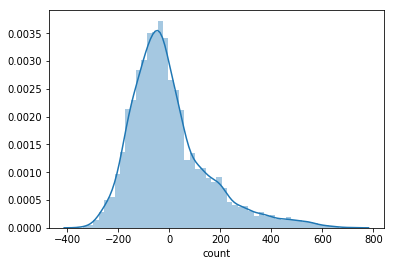

In [501]:
sns.distplot((y_test - predictions))

In [502]:
import math

#A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y_pred, y_test) : 
    assert len(y_test) == len(y_pred)
    return np.sqrt(np.mean((np.log(1+y_pred) - np.log(1+y_test))**2))

In [503]:
all_variables_rmsle = rmsle(predictions, y_test)

C:\Users\Clement\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


In [504]:
from sklearn import metrics
from sklearn.metrics import r2_score

In [505]:
all_variables_r2 = r2_score(y_test, predictions)

# Model with 'Season' Removed - weather may be a better predictor of demand than season

In [506]:
df_linear_reg_model_1 = df_linear_reg_model.drop(['Summer','Fall','Winter'], axis = 1)
df_linear_reg_model_1.head()

,holiday,workingday,temp,humidity,count,Misty,Light Snow,Heavy rain/snow
datetime,,,,,,,,
2011-01-01 00:00:00,0,0,9.84,81,16,0,0,0
2011-01-01 01:00:00,0,0,9.02,80,40,0,0,0
2011-01-01 02:00:00,0,0,9.02,80,32,0,0,0
2011-01-01 03:00:00,0,0,9.84,75,13,0,0,0
2011-01-01 04:00:00,0,0,9.84,75,1,0,0,0


In [507]:
x1 = df_linear_reg_model_1.drop('count', axis = 1)
y1 = df_linear_reg_model_1['count']

In [508]:
x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size = 0.4)

In [509]:
lm.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [510]:
results = pd.DataFrame(lm.coef_, x1.columns)
results

,0
holiday,-16.486217
workingday,2.513733
temp,8.466320
humidity,-2.779300
Misty,16.270201
Light Snow,-6.214708
Heavy rain/snow,144.798012


In [511]:
predictions = lm.predict(x_test)

In [512]:
no_season_r2 = r2_score(y_test, predictions)
no_season_rmsle = rmsle(predictions, y_test)

C:\Users\Clement\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


# Model with 'Weather' Removed

In [513]:
df_linear_reg_model_2 = df_linear_reg_model.drop(['Misty','Light Snow','Heavy rain/snow'], axis = 1)
df_linear_reg_model_2.head()

,holiday,workingday,temp,humidity,count,Summer,Fall,Winter
datetime,,,,,,,,
2011-01-01 00:00:00,0,0,9.84,81,16,0,0,0
2011-01-01 01:00:00,0,0,9.02,80,40,0,0,0
2011-01-01 02:00:00,0,0,9.02,80,32,0,0,0
2011-01-01 03:00:00,0,0,9.84,75,13,0,0,0
2011-01-01 04:00:00,0,0,9.84,75,1,0,0,0


In [514]:
x2 = df_linear_reg_model_2.drop('count', axis = 1)
y2 = df_linear_reg_model_2['count']

In [515]:
x_train, x_test, y_train, y_test = train_test_split(x2, y2, test_size = 0.4)

In [516]:
lm.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [517]:
results = pd.DataFrame(lm.coef_, x2.columns)
results

,0
holiday,-0.940867
workingday,-0.442364
temp,11.061582
humidity,-2.780066
Summer,-2.720477
Fall,-43.640520
Winter,67.948108


In [518]:
predictions = lm.predict(x_test)

In [519]:
no_weather_r2 = r2_score(y_test, predictions)
no_weather_rmsle = rmsle(predictions, y_test)

C:\Users\Clement\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


# Model with Holiday removed

In [520]:
df_linear_reg_model_3 = df_linear_reg_model.drop('holiday', axis = 1)
df_linear_reg_model_3.head()

,workingday,temp,humidity,count,Summer,Fall,Winter,Misty,Light Snow,Heavy rain/snow
datetime,,,,,,,,,,
2011-01-01 00:00:00,0,9.84,81,16,0,0,0,0,0,0
2011-01-01 01:00:00,0,9.02,80,40,0,0,0,0,0,0
2011-01-01 02:00:00,0,9.02,80,32,0,0,0,0,0,0
2011-01-01 03:00:00,0,9.84,75,13,0,0,0,0,0,0
2011-01-01 04:00:00,0,9.84,75,1,0,0,0,0,0,0


In [521]:
x3 = df_linear_reg_model_3.drop('count', axis = 1)
y3 = df_linear_reg_model_3['count']

In [522]:
x_train, x_test, y_train, y_test = train_test_split(x3, y3, test_size = 0.4)

In [523]:
lm.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [524]:
results = pd.DataFrame(lm.coef_, x3.columns)
results

,0
workingday,-0.426784
temp,10.728120
humidity,-2.885474
Summer,2.178154
Fall,-32.035014
Winter,64.960948
Misty,14.758777
Light Snow,-8.208002
Heavy rain/snow,182.500318


In [525]:
predictions = lm.predict(x_test)

In [526]:
no_holiday_r2 = r2_score(y_test, predictions)
no_holiday_rmsle = rmsle(predictions, y_test)

C:\Users\Clement\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


# Model with  'workingday' removed

In [527]:
df_linear_reg_model_4 = df_linear_reg_model.drop('workingday', axis = 1)
df_linear_reg_model_4.head()

,holiday,temp,humidity,count,Summer,Fall,Winter,Misty,Light Snow,Heavy rain/snow
datetime,,,,,,,,,,
2011-01-01 00:00:00,0,9.84,81,16,0,0,0,0,0,0
2011-01-01 01:00:00,0,9.02,80,40,0,0,0,0,0,0
2011-01-01 02:00:00,0,9.02,80,32,0,0,0,0,0,0
2011-01-01 03:00:00,0,9.84,75,13,0,0,0,0,0,0
2011-01-01 04:00:00,0,9.84,75,1,0,0,0,0,0,0


In [528]:
x4 = df_linear_reg_model_4.drop('count', axis = 1)
y4 = df_linear_reg_model_4['count']

In [529]:
x_train, x_test, y_train, y_test = train_test_split(x4, y4, test_size = 0.4)

In [530]:
lm.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [531]:
results = pd.DataFrame(lm.coef_, x4.columns)
results

,0
holiday,-4.078924
temp,11.572402
humidity,-2.781597
Summer,-5.421924
Fall,-46.726948
Winter,61.297598
Misty,10.553712
Light Snow,-6.846573
Heavy rain/snow,180.058925


In [532]:
predictions = lm.predict(x_test)

In [533]:
no_workingday_r2 = r2_score(y_test, predictions)
no_workingday_rmsle = rmsle(predictions, y_test)

C:\Users\Clement\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


In [534]:
result_summary = pd.DataFrame(index = ['All variables','Season Removed','weather removed','holiday removed','workingday removed'],
                                       columns = ['R-square','RMSLE'])

In [535]:
result_summary.loc['All variables'] = [all_variables_r2,all_variables_rmsle]

In [536]:
result_summary.iloc[1] = [no_season_r2, no_season_rmsle]

In [537]:
result_summary.iloc[2] = [no_weather_r2, no_weather_rmsle]

In [538]:
result_summary.iloc[3] = [no_holiday_r2, no_holiday_rmsle]

In [539]:
result_summary.iloc[4] = [no_workingday_r2, no_workingday_rmsle]

In [540]:
result_summary

,R-square,RMSLE
All variables,0.272449,1.36234
Season Removed,0.249116,1.37112
weather removed,0.281857,1.34673
holiday removed,0.27707,1.35313
workingday removed,0.273694,1.36608


# Utilizing 'all variables' model to predict demand on TEST data

In [561]:
df_test = pd.read_csv('test.csv')
df_test.drop(['season','weather','atemp','windspeed'], axis = 1, inplace=True)
df_test.head()

,datetime,holiday,workingday,temp,humidity
0,2011-01-20 00:00:00,0,1,10.66,56
1,2011-01-20 01:00:00,0,1,10.66,56
2,2011-01-20 02:00:00,0,1,10.66,56
3,2011-01-20 03:00:00,0,1,10.66,56
4,2011-01-20 04:00:00,0,1,10.66,56


In [557]:
test_season_dummy = pd.get_dummies(df_test['season'], drop_first=True)
test_season_dummy.columns = ['Summer', 'Fall', 'Winter']
test_season_dummy.head()

,Summer,Fall,Winter
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [558]:
test_weather_dummy = pd.get_dummies(df_test['weather'], drop_first=True)
test_weather_dummy.columns = ['Misty','Light Snow','Heavy rain/snow']
test_weather_dummy.head()

,Misty,Light Snow,Heavy rain/snow
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [562]:
df_test_input = pd.concat([df_test,test_season_dummy, test_weather_dummy], axis = 1)
df_test_input.set_index('datetime',inplace = True)

In [563]:
df_test_input.head()

,holiday,workingday,temp,humidity,Summer,Fall,Winter,Misty,Light Snow,Heavy rain/snow
datetime,,,,,,,,,,
2011-01-20 00:00:00,0,1,10.66,56,0,0,0,0,0,0
2011-01-20 01:00:00,0,1,10.66,56,0,0,0,0,0,0
2011-01-20 02:00:00,0,1,10.66,56,0,0,0,0,0,0
2011-01-20 03:00:00,0,1,10.66,56,0,0,0,0,0,0
2011-01-20 04:00:00,0,1,10.66,56,0,0,0,0,0,0


In [572]:
test_predictions = pd.DataFrame(lm.predict(df_test_input))

In [573]:
test_predictions.head()

,0
0,93.75636
1,93.75636
2,93.75636
3,93.75636
4,93.75636


In [581]:
results_submission = pd.concat([df_test['datetime'], test_predictions], axis = 1)
results_submission.columns = ['datetime','count']
results_submission.head()

,datetime,count
0,2011-01-20 00:00:00,93.75636
1,2011-01-20 01:00:00,93.75636
2,2011-01-20 02:00:00,93.75636
3,2011-01-20 03:00:00,93.75636
4,2011-01-20 04:00:00,93.75636


In [584]:
results_submission.to_csv('test_predictions')

# Results submitted to Kaggle, returning with RMSLE score of 1.43 
- lower score indicates less deviation of predicted from actual score. Lowest RMSLE was 0.33; highest RMSLE submitted was 4.76)

# Results will be updated, pending new iterations to improve predictive ability